In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#データの読み込み
meal = pd.read_csv("/content/Meal Analysis (2017) - data.csv", index_col=0)
print(len(meal))
meal.head(8)

1315


,Type,gender,age,height,weight,EER[kcal],P target(15%)[g],F target(25%)[g],C target(60%)[g],number of dishes,E[kcal],P[g],F[g],C[g],Salt[g],Vegetables[g],Score(1:worst 2:bad 3:good 4:best)
1,breakfast,female,32.0,157.0,48.0,1655,62,46,248,2,334,5.9,0.8,75.7,0.2,29,2
2,breakfast,female,35.0,161.0,55.0,2073,78,58,311,2,214,4.6,4.5,41.3,0.1,0,1
3,breakfast,female,26.0,159.0,51.0,2042,77,57,306,4,352,27.3,18.9,18.1,2.8,116,2
4,breakfast,female,48.0,164.0,57.0,1772,66,49,266,2,295,5.6,0.9,65.1,0.7,189,2
5,dinner,female,48.0,164.0,57.0,1772,66,49,266,5,876,41.5,34.2,96.3,6.4,54,2
6,lunch,female,48.0,164.0,57.0,1772,66,49,266,1,424,14.5,25.0,34.4,2.3,33,2
7,breakfast,female,48.0,164.0,57.0,1772,66,49,266,1,347,11.1,8.6,54.0,2.0,6,2
8,NaN,NaN,NaN,NaN,NaN,1772,66,49,266,3,238,6.1,10.9,31.1,1.6,299,3


In [ ]:
#欠損値のあるレコードを確認
for i in range(1,len(meal)): 
  if meal.isnull().any(axis=1)[i] == True:
    print(i)

8


In [ ]:
#欠損値のあるレコードを削除
meal = meal.dropna()
print(len(meal))
meal = meal.reset_index(drop=True)
meal.head(8)

1314


,Type,gender,age,height,weight,EER[kcal],P target(15%)[g],F target(25%)[g],C target(60%)[g],number of dishes,E[kcal],P[g],F[g],C[g],Salt[g],Vegetables[g],Score(1:worst 2:bad 3:good 4:best)
0,breakfast,female,32.0,157.0,48.0,1655,62,46,248,2,334,5.9,0.8,75.7,0.2,29,2
1,breakfast,female,35.0,161.0,55.0,2073,78,58,311,2,214,4.6,4.5,41.3,0.1,0,1
2,breakfast,female,26.0,159.0,51.0,2042,77,57,306,4,352,27.3,18.9,18.1,2.8,116,2
3,breakfast,female,48.0,164.0,57.0,1772,66,49,266,2,295,5.6,0.9,65.1,0.7,189,2
4,dinner,female,48.0,164.0,57.0,1772,66,49,266,5,876,41.5,34.2,96.3,6.4,54,2
5,lunch,female,48.0,164.0,57.0,1772,66,49,266,1,424,14.5,25.0,34.4,2.3,33,2
6,breakfast,female,48.0,164.0,57.0,1772,66,49,266,1,347,11.1,8.6,54.0,2.0,6,2
7,dinner,female,48.0,164.0,57.0,1772,66,49,266,1,563,22.5,20.3,67.9,2.2,125,2


In [ ]:
#説明変数xと目的変数yに分割
x = meal.drop("Score(1:worst 2:bad 3:good 4:best)", axis=1)
y = meal["Score(1:worst 2:bad 3:good 4:best)"]
x.head()

,Type,gender,age,height,weight,EER[kcal],P target(15%)[g],F target(25%)[g],C target(60%)[g],number of dishes,E[kcal],P[g],F[g],C[g],Salt[g],Vegetables[g]
0,breakfast,female,32.0,157.0,48.0,1655,62,46,248,2,334,5.9,0.8,75.7,0.2,29
1,breakfast,female,35.0,161.0,55.0,2073,78,58,311,2,214,4.6,4.5,41.3,0.1,0
2,breakfast,female,26.0,159.0,51.0,2042,77,57,306,4,352,27.3,18.9,18.1,2.8,116
3,breakfast,female,48.0,164.0,57.0,1772,66,49,266,2,295,5.6,0.9,65.1,0.7,189
4,dinner,female,48.0,164.0,57.0,1772,66,49,266,5,876,41.5,34.2,96.3,6.4,54


(array([320.,   0.,   0., 757.,   0.,   0., 200.,   0.,   0.,  37.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

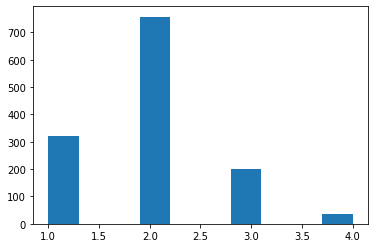

In [ ]:
#目的変数の分布を確認
import matplotlib.pyplot as plt
plt.hist(y)

In [ ]:
#xが文字列ならダミー化, 目的変数が数字なら標準化(平均値0, 分散1)の処理を施す
x_dum = []
name = x.columns

for i in range(0,len(meal.columns)-1):
  for j in range(1, len(x)):
    if type(x[name[i]][j]) == str:
      x_dum.append(name[i])
    else:
      x[name[i]] = (x[name[i]] - x.describe()[name[i]]["mean"]) / x.describe()[name[i]]["std"]
    break

dum = pd.get_dummies(x[x_dum])
x = x.drop(x_dum, axis=1)
x = pd.concat((dum, x), axis=1)

x.head()

,Type_breakfast,Type_dinner,Type_lunch,gender_female,gender_male,age,height,weight,EER[kcal],P target(15%)[g],F target(25%)[g],C target(60%)[g],number of dishes,E[kcal],P[g],F[g],C[g],Salt[g],Vegetables[g]
0,1,0,0,1,0,-0.822195,-1.471389,-1.280390,-1.663889,-1.677263,-1.639961,-1.670243,-0.438054,-0.845403,-1.204255,-1.253072,0.170759,-1.408087,-0.540437
1,1,0,0,1,0,-0.501992,-0.855900,-0.443894,-0.330383,-0.311706,-0.273067,-0.329975,-0.438054,-1.233697,-1.305799,-1.049410,-0.778753,-1.458203,-0.899423
2,1,0,0,1,0,-1.462601,-1.163645,-0.921892,-0.429279,-0.397053,-0.386975,-0.436346,0.801134,-0.787159,0.467307,-0.256776,-1.419121,-0.105075,0.536518
3,1,0,0,1,0,0.885553,-0.394283,-0.204895,-1.290635,-1.335874,-1.298237,-1.287310,-0.438054,-0.971599,-1.227688,-1.247568,-0.121823,-1.157508,1.440171
4,0,1,0,1,0,0.885553,-0.394283,-0.204895,-1.290635,-1.335874,-1.298237,-1.287310,1.420727,0.908390,1.576474,0.585398,0.739362,1.699095,-0.230967


In [ ]:
import urllib.request 
from sklearn.decomposition import PCA #主成分分析器

In [ ]:
#xを主成分分析にかける
pca = PCA()
pca.fit(x)
feature = pca.transform(x)

In [ ]:
#主成分得点
pc = pd.DataFrame(feature, columns=["PC{}".format(i + 1) for i in range(len(x.columns))])

In [ ]:
#寄与率
pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(i + 1) for i in range(len(x.columns))])

,0
PC1,3.502089e-01
PC2,2.591543e-01
PC3,7.949526e-02
PC4,6.646527e-02
PC5,5.531355e-02
PC6,4.617458e-02
PC7,4.228174e-02
PC8,2.926335e-02
PC9,2.075785e-02
PC10,1.749474e-02


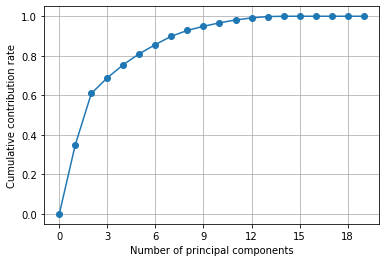

In [ ]:
#累積寄与率をプロット
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.savefig("variance.eps")
plt.show()

In [ ]:
#得られた主成分
pc_parm = pd.DataFrame(pca.components_, columns=x.columns[0:], index=["PC{}".format(i+1) for i in range(len(x.columns))])

In [ ]:
#ランダムフォレストによる分類器を呼び出す
#yの分布が不均衡なため, class_weight = "balanced"とした
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight="balanced")

In [ ]:
#投入するPCの数を順次増やしながらそれぞれの精度を測る
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
sc = []
fs = []
pc2 = pd.DataFrame()

for i,feat in enumerate(pc):
  pc2 = pd.concat([pc2, pc[feat]], axis=1)
  PC_train, PC_test, y_train, y_test = train_test_split(pc2, y, test_size=0.4, random_state=0)
  clf.fit(PC_train, y_train)
  sc.append(clf.score(PC_test, y_test))
  fs.append(f1_score(y_test, clf.predict(PC_test), average=None))

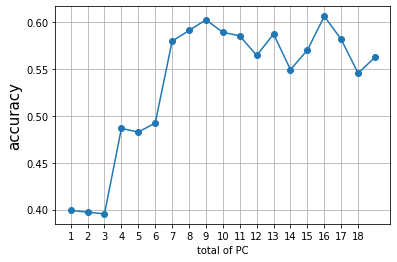

In [ ]:
#正解率をプロット

plt.plot(range(1, len(pc2.columns)+1), sc, "-o")

start, end = 1, 19
stepsize = 1

#plt.title("accuracy per total of PC", fontsize=20)
plt.xticks (np.arange(start, end, stepsize)) 
plt.xlabel('total of PC')
plt.ylabel("accuracy", fontsize=15)

plt.grid()
plt.savefig("accu.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


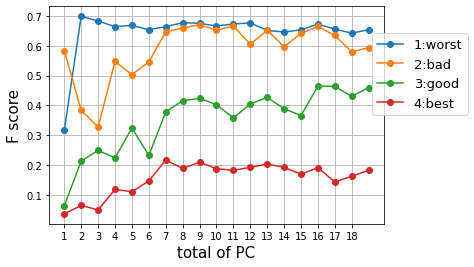

In [ ]:
#F値をプロット

fs_data = pd.DataFrame(fs, columns=["1:worst", "2:bad", "3:good", "4:best"])
worst = fs_data["1:worst"]
bad = fs_data["2:bad"]
good = fs_data["3:good"]
best = fs_data["4:best"]

plt.plot(range(1, len(pc2.columns)+1), worst, "-o", label="1:worst")
plt.plot(range(1, len(pc2.columns)+1), bad, "-o", label="2:bad")
plt.plot(range(1, len(pc2.columns)+1), good, "-o", label="3:good")
plt.plot(range(1, len(pc2.columns)+1), best, "-o", label="4:best")

start, end = 1, 19
stepsize = 1


#plt.title("F score per label", fontsize=20)
plt.xticks (np.arange(start, end, stepsize)) 
plt.xlabel("total of PC", fontsize=15)
plt.ylabel("F score", fontsize=15)

plt.grid()


plt.legend(bbox_to_anchor=(1.25, 0.5), loc='lower right', borderaxespad=0, fontsize=13)
plt.savefig("fscore.eps", bbox_inches='tight')
plt.show()

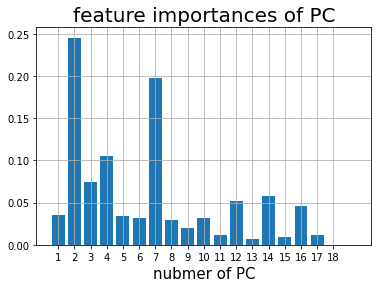

In [ ]:
#分類器の設定した変数に対する重みをプロット

plt.bar(range(1, len(clf.feature_importances_)+1), clf.feature_importances_)
plt.xlabel("nubmer of PC", fontsize=15)
plt.title("feature importances of PC", fontsize=20)
start, end = 1, 19
stepsize = 1

plt.grid()
plt.xticks (np.arange(start, end, stepsize)) 
plt.savefig("feature.eps")


In [ ]:
#主成分を重みの大きい順に並べ替える

tmp = clf.feature_importances_
ind = list(range(1,len(tmp)+1))

for i in range(0, len(tmp)-1):
  for j in range(i+1, len(tmp)):
    if tmp[i] <= tmp[j]:
     tmp[i], tmp[j] = tmp[j], tmp[i]
     ind[i], ind[j] = ind[j], ind[i]

ind = ["PC{}".format(ind[i]) for i in range(len(ind))]

In [ ]:
#重みの大きい主成分から順に投入して精度を測る

sc2 = []
fs2 = []
pc2 = pd.DataFrame()

for i,feat in enumerate(ind):
  pc2 = pd.concat([pc2, pc[feat]], axis=1)
  PC_train, PC_test, y_train, y_test = train_test_split(pc2, y, test_size=0.4, random_state=0)
  clf.fit(PC_train, y_train)
  sc2.append(clf.score(PC_test, y_test))
  fs2.append(f1_score(y_test, clf.predict(PC_test), average=None))

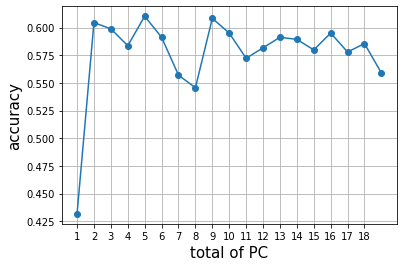

In [ ]:
#正解率のプロット
plt.plot(range(1, len(pc2.columns)+1), sc2, "-o")

start, end = 1, 19
stepsize = 1

plt.xticks (np.arange(start, end, stepsize)) 
plt.xlabel("total of PC", fontsize=15)
plt.ylabel("accuracy", fontsize=15)

plt.grid()
plt.savefig("accu2.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


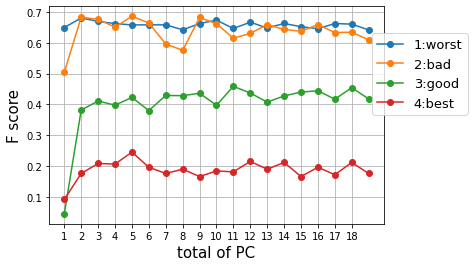

In [ ]:
#F値のプロット
fs2_data = pd.DataFrame(fs2, columns=["1:worst", "2:bad", "3:good", "4:best"])

worst = fs2_data["1:worst"]
bad = fs2_data["2:bad"]
good = fs2_data["3:good"]
best = fs2_data["4:best"]

plt.plot(range(1, len(pc2.columns)+1), worst, "-o", label="1:worst")
plt.plot(range(1, len(pc2.columns)+1), bad, "-o", label="2:bad")
plt.plot(range(1, len(pc2.columns)+1), good, "-o", label="3:good")
plt.plot(range(1, len(pc2.columns)+1), best, "-o", label="4:best")

start, end = 1, 19
stepsize = 1

plt.xticks (np.arange(start, end, stepsize)) 
plt.xlabel("total of PC", fontsize=15)
plt.ylabel("F score", fontsize=15)

plt.grid()


plt.legend(bbox_to_anchor=(1.25, 0.5), loc='lower right', borderaxespad=0, fontsize=13)
plt.savefig("fscore2.eps", bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


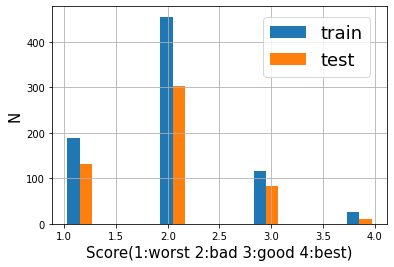

In [ ]:
#yのテストデータと訓練データのヒストグラム
plt.hist((y_train, y_test), label=["train", "test"])
plt.grid()

plt.legend(bbox_to_anchor=(0.95, 0.95), loc='upper right', borderaxespad=0, fontsize=18)

plt.xlabel("Score(1:worst 2:bad 3:good 4:best)", fontsize=15)
plt.ylabel("N", fontsize=15)

plt.savefig("label.eps")

In [ ]:
#正解率とF値の結果から重みの大きい主成分を5つ採用することにした
pc3 = pc[ind[0:5]]
pc_test = pd.DataFrame(pc3
                       #.loc[y_test.index]
                       )

In [ ]:
y_test_df = pd.concat((pc_test, y), axis=1)
y_test_df.head(8)

,PC2,PC7,PC4,PC3,PC14,Score(1:worst 2:bad 3:good 4:best)
0,-0.684983,-0.392066,-0.800586,0.538926,-0.017594,2
1,-2.260374,0.106004,0.068268,0.798101,-0.015140,1
2,0.096641,0.158788,0.576818,2.100192,0.014131,2
3,-0.572415,-1.892490,0.641912,-1.004114,0.046503,2
4,3.456380,0.651688,0.183290,-0.841936,-0.063091,2
5,-0.166356,0.173272,-0.515157,-1.151758,0.045740,2
6,-0.854104,-0.176305,-0.507307,-1.199135,0.077728,2
7,0.809889,-0.836836,-0.339122,-1.141031,-0.041439,2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


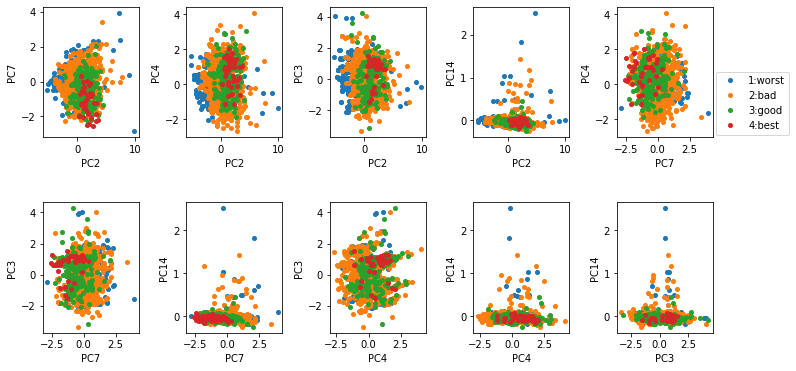

In [ ]:
#テストデータの主成分得点の散布図をプロット

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

labels = ["1:worst", "2:bad", "3:good", "4:best"]
groups = y_test_df.groupby("Score(1:worst 2:bad 3:good 4:best)")

counti, countj = 0, 0

for i in range(0, len(y_test_df.columns)-2):
  for j in range(i+1, len(y_test_df.columns)-1):
    colx, coly = y_test_df.columns[i], y_test_df.columns[j]
    for l, (status, group) in zip(labels, groups):
      ax[counti,countj].plot(group[colx], group[coly],marker='o', linestyle='', ms=4, label=l)
      ax[counti,countj].set(xlabel=colx, ylabel=coly)
    countj = countj + 1  
    if(countj >= 5):
      counti = counti + 1
      countj = 0

plt.legend(bbox_to_anchor=(1.8, 2.0), loc='upper right', borderaxespad=0, fontsize=10)
plt.savefig("opi.eps")
plt.show()

In [ ]:
#主成分をcsvファイルとして保存
round(pc_parm.T[ind[0:5]], 3).to_csv("pc_parm.csv")

In [ ]:
#正解率とF値の推移をcsvファイルとして保存
pd.DataFrame(np.c_[sc, fs, sc2, fs2]).to_csv("acuuracy_fscore.csv")